# Wykład 12: Projektowanie sieci ConvNet

Na tym wykładzie zaprojektujemy sami sieci ConvNet i prostymi zastosowaniami

Zobaczymy także trzy różne metody definiowania modeli w Kerasie:

- Sekewncyjny (Sequential)
- Funcjonalny (Functional)
- Zorientowany obietkowo (Object-Oriented)

Uwaga: Celem tego wykładu nie jest porównanie wydajności, ale tylko samych architektur

### Wczytywanie danych (MNIST)

In [2]:
from tensorflow.keras import datasets
from sklearn.model_selection import train_test_split

(x_train, y_train), (x_test, y_test) = datasets.mnist.load_data()
h, w = x_train.shape[1:]

x_train = x_train.reshape(x_train.shape[0], h, w, 1)
x_test = x_test.reshape(x_test.shape[0], h, w, 1)
input_shape = (h, w, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=10000, random_state=42)

(x_train.shape, y_train.shape), (x_val.shape, y_val.shape), (x_test.shape, y_test.shape)

(((50000, 28, 28, 1), (50000,)),
 ((10000, 28, 28, 1), (10000,)),
 ((10000, 28, 28, 1), (10000,)))

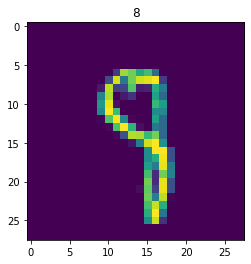

In [3]:
import matplotlib.pyplot as plt

plt.imshow(x_train[0].squeeze(-1))
plt.title(y_train[0]);

In [4]:
import numpy as np

print("{} unique labels.".format(np.unique(y_train)))

[0 1 2 3 4 5 6 7 8 9] unique labels.


## 1. LeNet

Na początku zdefiniujemy klasyczny model LeNet-5 wprowadzony przez Yann Le Cun in 1998 ([url](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf)). Model jest na tyle prosty, że możemy go łatwo zdefiniować z wykorzystaniem **Sequential** API.

![lenet archi](images/lenet.png)

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, AvgPool2D, MaxPool2D, Dense, Flatten
from tensorflow.keras import optimizers

lenet = Sequential(name="LeNet-5")

lenet.add(Conv2D(6, kernel_size=(5, 5), activation="tanh", padding="same", input_shape=input_shape, name="C1"))
lenet.add(MaxPool2D(pool_size=(2, 2), name="S2"))
lenet.add(Conv2D(16, kernel_size=(5, 5), activation='tanh', name="C3"))
lenet.add(AvgPool2D(pool_size=(2, 2), name="S4"))
lenet.add(Conv2D(120, kernel_size=(5, 5), activation='tanh', name="C5"))
lenet.add(Flatten())
lenet.add(Dense(84, activation='tanh', name="F6"))
lenet.add(Dense(10, activation='softmax'))

lenet.summary()

Model: "LeNet-5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
C1 (Conv2D)                  (None, 28, 28, 6)         156       
_________________________________________________________________
S2 (MaxPooling2D)            (None, 14, 14, 6)         0         
_________________________________________________________________
C3 (Conv2D)                  (None, 10, 10, 16)        2416      
_________________________________________________________________
S4 (AveragePooling2D)        (None, 5, 5, 16)          0         
_________________________________________________________________
C5 (Conv2D)                  (None, 1, 1, 120)         48120     
_________________________________________________________________
flatten (Flatten)            (None, 120)               0         
_________________________________________________________________
F6 (Dense)                   (None, 84)                1016

In [6]:
n_epochs = 5
batch_size = 256

lenet.compile(
    optimizer=optimizers.SGD(lr=0.1),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

lenet.fit(
    x_train, y_train,
    epochs=n_epochs,
    batch_size=batch_size,
    validation_data=(x_val, y_val)
)

Epoch 1/5
196/196 [==============================] - 11s 54ms/step - loss: 0.6170 - accuracy: 0.8386 - val_loss: 0.3270 - val_accuracy: 0.9004
Epoch 2/5
196/196 [==============================] - 11s 54ms/step - loss: 0.2466 - accuracy: 0.9275 - val_loss: 0.2115 - val_accuracy: 0.9350
Epoch 3/5
196/196 [==============================] - 10s 53ms/step - loss: 0.1711 - accuracy: 0.9504 - val_loss: 0.1439 - val_accuracy: 0.9577
Epoch 4/5
196/196 [==============================] - 11s 57ms/step - loss: 0.1300 - accuracy: 0.9616 - val_loss: 0.1118 - val_accuracy: 0.9693
Epoch 5/5
196/196 [==============================] - 12s 63ms/step - loss: 0.1059 - accuracy: 0.9688 - val_loss: 0.0963 - val_accuracy: 0.9731


In [7]:
lenet.evaluate(x_test, y_test, verbose=1)

313/313 [==============================] - 2s 7ms/step - loss: 0.0900 - accuracy: 0.9723


[0.09002140164375305, 0.9722999930381775]

Uwaga: LeNet został na początku zdefiniowany z wykorzystaniem funkcji aktywacji `tanh` lub `sigmoid`, aktualnie
te funkcje aktywacji są rzadko używane. Można pokazać, że obie funkcje "nasycają się" (saturate)
dla bardzo małych i bardzo dużych wartości co powoduje "zanik" gradientu.

Dlatego aktualnie większość sieci wykorzystuje `ReLU` w warstwach ukrytych lub inne o podobnych własnościach
(https://keras.io/layers/advanced-activations/).


## 2. Inception

Model "Inception" został wprowadzony w 2014 przez Szegedy et al. ([paper url](https://arxiv.org/abs/1409.4842)).

Konwolucje mają efektywne "pole chłonności" (receptive field): im większe "kernels" i im głębszy (deeper) model, tym więcej pikseli obrazu *zobaczymy*. Dobrze wyjaśnienia to: [medium blog](https://medium.com/mlreview/a-guide-to-receptive-field-arithmetic-for-convolutional-neural-networks-e0f514068807).

W modelu tym, różne "convolution kernels" są ze sobą łączone. Mniejsze "kernels" wykorzystywane są do mniejszych
klastrów cech (można myśleć o tym jak o detalach np. oko), podchas duże "kernels" dla większych kastrów cech
(np. twarz)

![inception archi](images/inception.png)

Tym razem wykorzystamy **Functional** API  do zdefiniowania pojedynczej warstwy "Inception layer"

Przykład:

```python
a = Input(shape=(32,))
b = Dense(32)(a)
model = Model(inputs=a, outputs=b)
```

In [8]:
from tensorflow.keras.layers import Concatenate, Input
from tensorflow.keras.models import Model

from tensorflow.keras.layers import Concatenate, Input
from tensorflow.keras.models import Model


def inception_layer(tensor, n_filters):
    branch1x1 = Conv2D(n_filters, kernel_size=(1, 1), activation="relu", padding="same")(tensor)
    branch5x5 = Conv2D(n_filters, kernel_size=(5, 5), activation="relu", padding="same")(tensor)
    branch3x3 = Conv2D(n_filters, kernel_size=(3, 3), activation="relu", padding="same")(tensor)

    branch_pool = MaxPool2D(pool_size=(3, 3), strides=(1, 1), padding="same")(tensor)

    output = Concatenate(axis=-1)(
        [branch1x1, branch5x5, branch3x3, branch_pool]
    )
    return output


input_tensor = Input(shape=input_shape)
x = Conv2D(16, kernel_size=(5, 5), padding="same")(input_tensor)
x = inception_layer(x, 32)
x = Flatten()(x)
output_tensor = Dense(10, activation="softmax")(x)

mini_inception = Model(inputs=input_tensor, outputs=output_tensor)

mini_inception.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 28, 28, 16)   416         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 32)   544         conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 28, 28, 32)   12832       conv2d[0][0]                     
______________________________________________________________________________________________

In [9]:
n_epochs = 5
batch_size = 256

mini_inception.compile(
    optimizer=optimizers.SGD(lr=0.1),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

mini_inception.fit(
    x_train, y_train,
    epochs=n_epochs,
    batch_size=batch_size,
    validation_data=(x_val, y_val)
)

Epoch 1/5
196/196 [==============================] - 90s 461ms/step - loss: 0.3232 - accuracy: 0.9032 - val_loss: 0.1722 - val_accuracy: 0.9467
Epoch 2/5
196/196 [==============================] - 83s 423ms/step - loss: 0.1115 - accuracy: 0.9687 - val_loss: 0.1655 - val_accuracy: 0.9479
Epoch 3/5
196/196 [==============================] - 83s 424ms/step - loss: 0.0717 - accuracy: 0.9792 - val_loss: 0.0739 - val_accuracy: 0.9773
Epoch 4/5
196/196 [==============================] - 83s 424ms/step - loss: 0.0578 - accuracy: 0.9818 - val_loss: 0.0704 - val_accuracy: 0.9798
Epoch 5/5
196/196 [==============================] - 83s 426ms/step - loss: 0.0485 - accuracy: 0.9852 - val_loss: 0.0590 - val_accuracy: 0.9825


In [10]:
mini_inception.evaluate(x_test, y_test, verbose=1)

313/313 [==============================] - 5s 15ms/step - loss: 0.0467 - accuracy: 0.9843


[0.04670601338148117, 0.9843000173568726]

## 3. ResNet

ResNet (*Residual Networks*) model został wprowadzony przez He et al. in 2015 ([paper url](https://arxiv.org/abs/1512.03385)). Autorzy pracy zauważyli, że więcej warstw znacznie poprawia wydajność sieci, niestety
bardzo trudno uczyć takie sieci (backpropagate the gradients).

Trik który pozwalał uczyć takie sieci umożliwiając łatwiejszy "przepływ" gradientu polega na wprowadzeniu skrótów

![resnet archi](images/resnet.png)

Tym razem wykorzystamy **Oriented-Object** API:

Przykład:
```python
class MyModel(Model):
    def __init__(self):
        self.classifier = Dense(10, activation="softmax")
        
    def call(self, inputs):
        return self.classifier(inputs)
```

In [11]:
from tensorflow.keras.layers import Add, Layer, Activation


class ResidualBlock(Layer):
    def __init__(self, n_filters):
        super().__init__(name="ResidualBlock")

        self.conv1 = Conv2D(n_filters, kernel_size=(3, 3), activation="relu", padding="same")
        self.conv2 = Conv2D(n_filters, kernel_size=(3, 3), padding="same")
        self.add = Add()
        self.last_relu = Activation("relu")

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.conv2(inputs)

        y = self.add([x, inputs])
        y = self.last_relu(y)

        return y


class MiniResNet(Model):
    def __init__(self, n_filters):
        super().__init__()

        self.conv = Conv2D(n_filters, kernel_size=(5, 5), padding="same")
        self.block = ResidualBlock(n_filters)
        self.flatten = Flatten()
        self.classifier = Dense(10, activation="softmax")

    def call(self, inputs):
        x = self.conv(inputs)
        x = self.block(x)
        x = self.flatten(x)
        y = self.classifier(x)

        return y


mini_resnet = MiniResNet(32)
mini_resnet.build((None, *input_shape))
mini_resnet.summary()


Model: "mini_res_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            multiple                  832       
_________________________________________________________________
ResidualBlock (ResidualBlock multiple                  18496     
_________________________________________________________________
flatten_2 (Flatten)          multiple                  0         
_________________________________________________________________
dense_2 (Dense)              multiple                  250890    
Total params: 270,218
Trainable params: 270,218
Non-trainable params: 0
_________________________________________________________________


In [12]:
n_epochs = 5
batch_size = 256

mini_resnet.compile(
    optimizer=optimizers.SGD(lr=0.1),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

mini_resnet.fit(
    x_train, y_train,
    epochs=n_epochs,
    batch_size=batch_size,
    validation_data=(x_val, y_val)
)

Epoch 1/5
196/196 [==============================] - 40s 205ms/step - loss: 0.3430 - accuracy: 0.9022 - val_loss: 0.1386 - val_accuracy: 0.9593
Epoch 2/5
196/196 [==============================] - 39s 200ms/step - loss: 0.1127 - accuracy: 0.9668 - val_loss: 0.1022 - val_accuracy: 0.9687
Epoch 3/5
196/196 [==============================] - 39s 199ms/step - loss: 0.0848 - accuracy: 0.9742 - val_loss: 0.0996 - val_accuracy: 0.9697
Epoch 4/5
196/196 [==============================] - 39s 199ms/step - loss: 0.0698 - accuracy: 0.9794 - val_loss: 0.0746 - val_accuracy: 0.9780
Epoch 5/5
196/196 [==============================] - 39s 199ms/step - loss: 0.0602 - accuracy: 0.9811 - val_loss: 0.0786 - val_accuracy: 0.9768


In [13]:
mini_resnet.evaluate(x_test, y_test, verbose=1)

313/313 [==============================] - 2s 7ms/step - loss: 0.0677 - accuracy: 0.9784


[0.06772437691688538, 0.9783999919891357]